Epoch 2000: Real Acc: 0.48, Fake Acc: 0.50


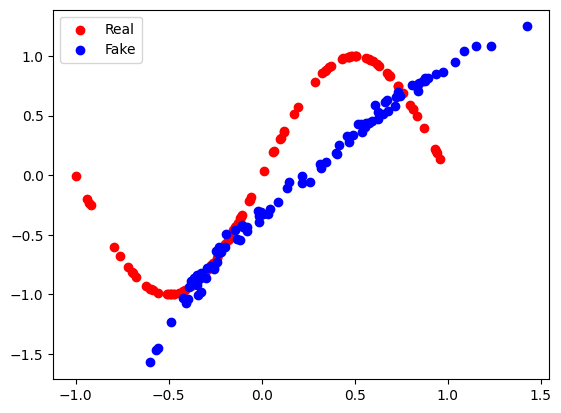

Epoch 4000: Real Acc: 0.62, Fake Acc: 0.51


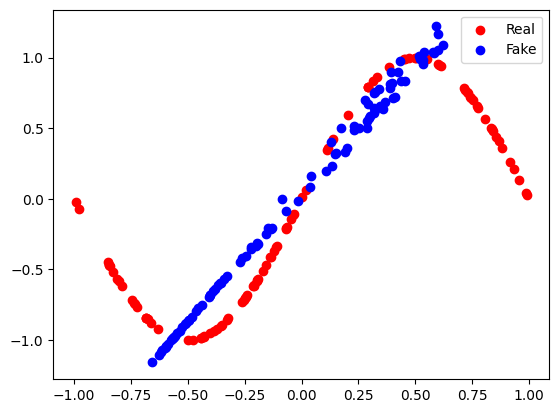

Epoch 6000: Real Acc: 0.35, Fake Acc: 0.42


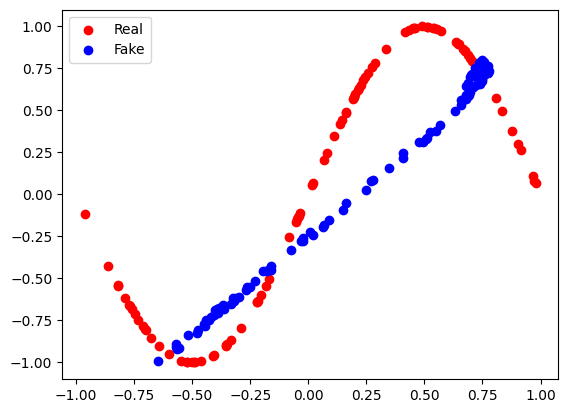

Epoch 8000: Real Acc: 0.55, Fake Acc: 0.55


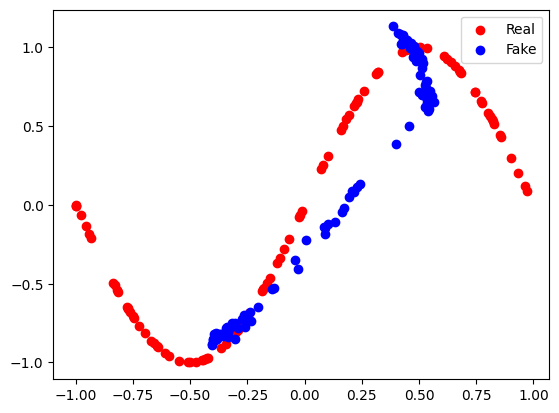

Epoch 10000: Real Acc: 0.39, Fake Acc: 0.52


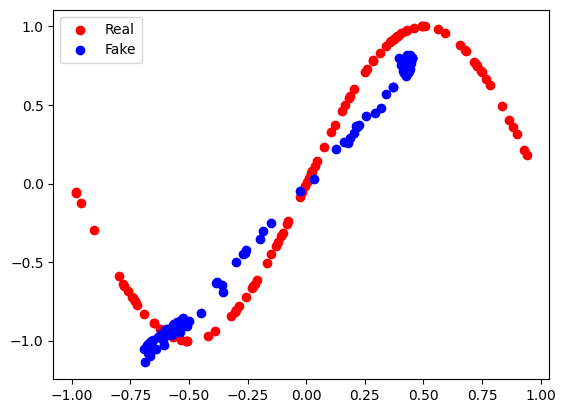

Epoch 12000: Real Acc: 0.47, Fake Acc: 0.57


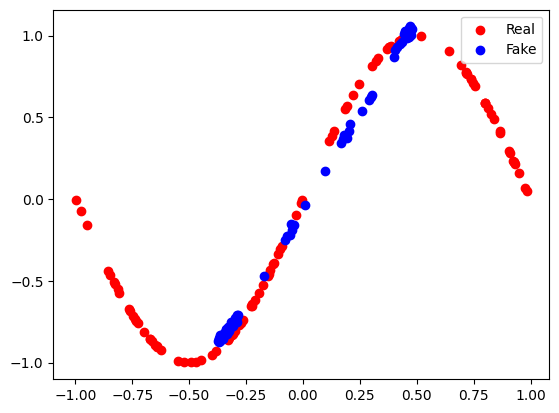

Epoch 14000: Real Acc: 0.39, Fake Acc: 0.09


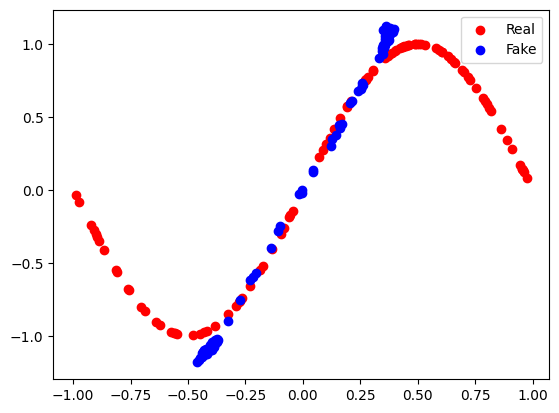

Epoch 16000: Real Acc: 0.49, Fake Acc: 0.38


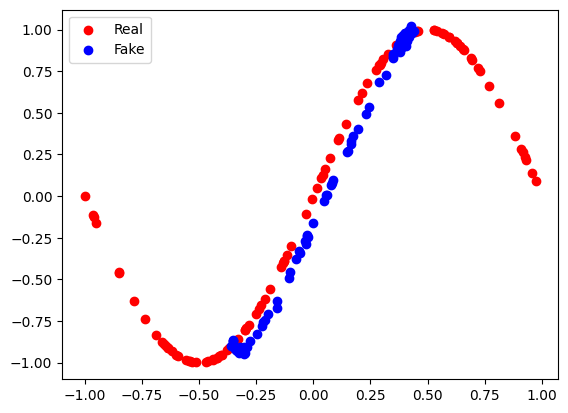

Epoch 18000: Real Acc: 0.48, Fake Acc: 0.60


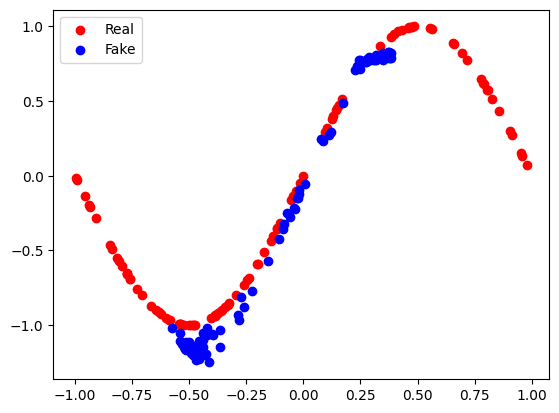

Epoch 20000: Real Acc: 0.68, Fake Acc: 0.70


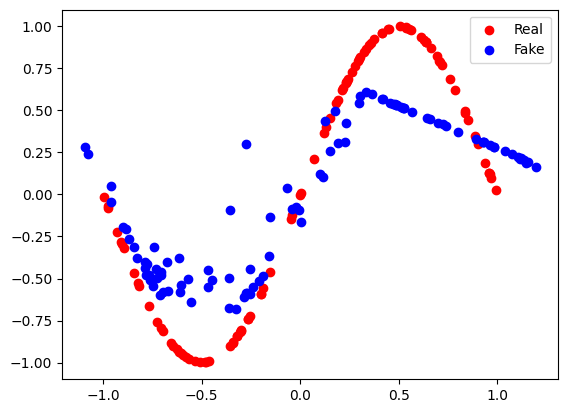

Epoch 22000: Real Acc: 0.58, Fake Acc: 0.53


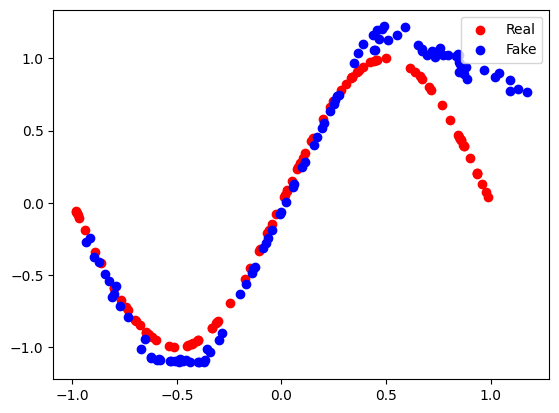

Epoch 24000: Real Acc: 0.56, Fake Acc: 0.59


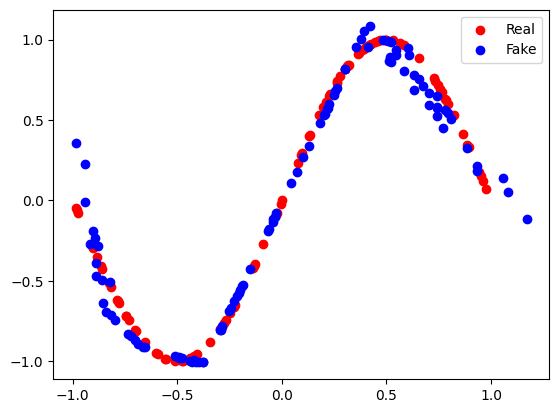

Epoch 26000: Real Acc: 0.57, Fake Acc: 0.65


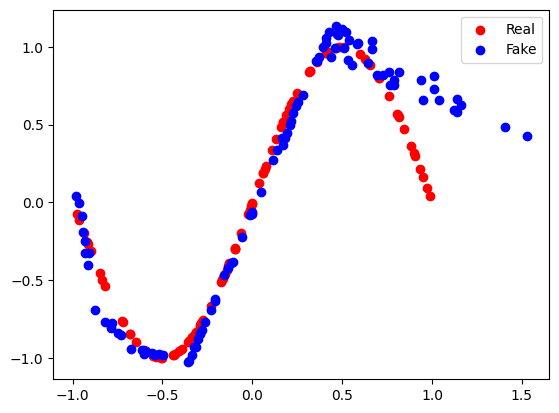

Epoch 28000: Real Acc: 0.52, Fake Acc: 0.57


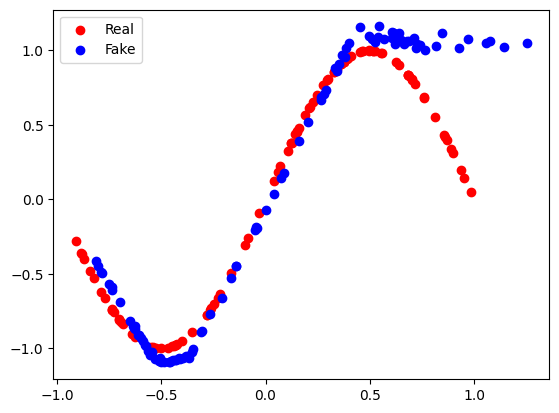

Epoch 30000: Real Acc: 0.62, Fake Acc: 0.51


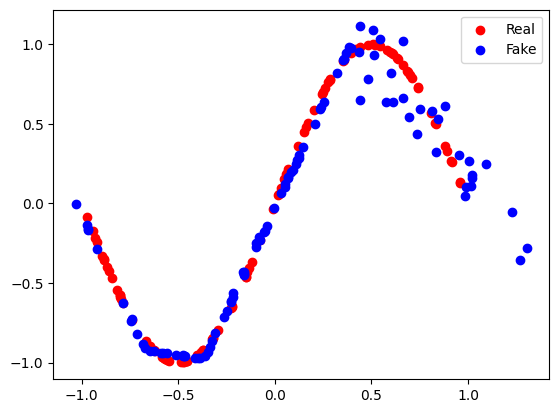

Epoch 32000: Real Acc: 0.51, Fake Acc: 0.63


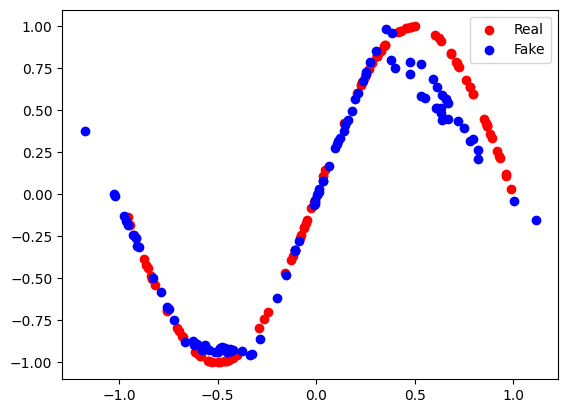

Epoch 34000: Real Acc: 0.47, Fake Acc: 0.60


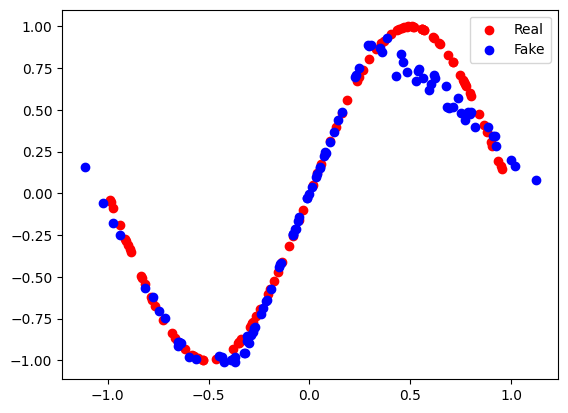

Epoch 36000: Real Acc: 0.40, Fake Acc: 0.70


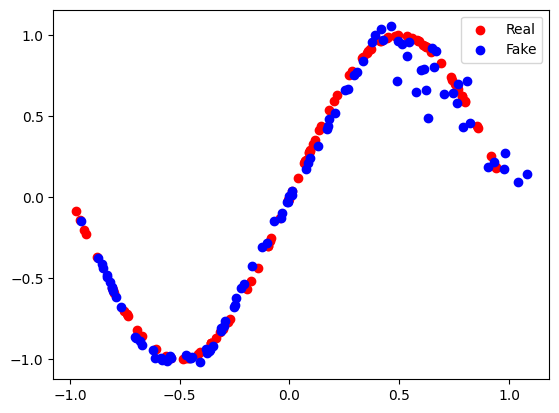

Epoch 38000: Real Acc: 0.71, Fake Acc: 0.36


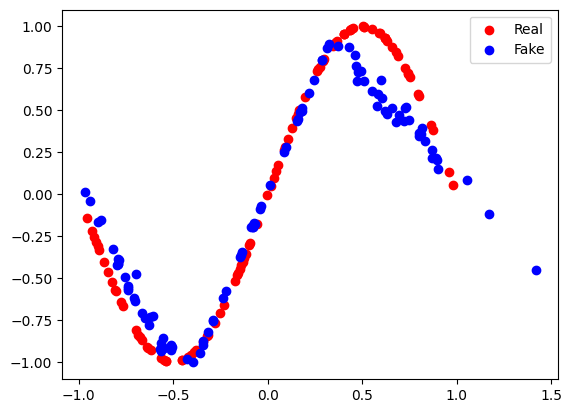

Epoch 40000: Real Acc: 0.53, Fake Acc: 0.45


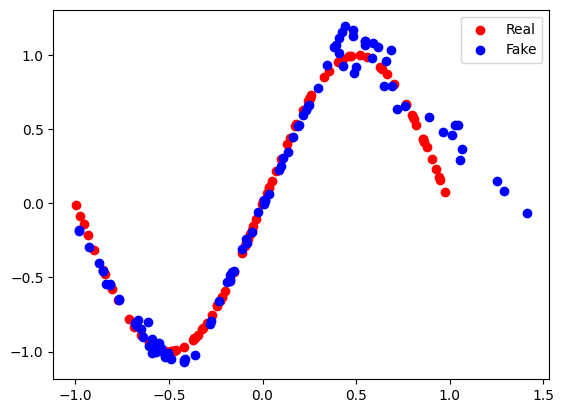

Epoch 42000: Real Acc: 0.47, Fake Acc: 0.45


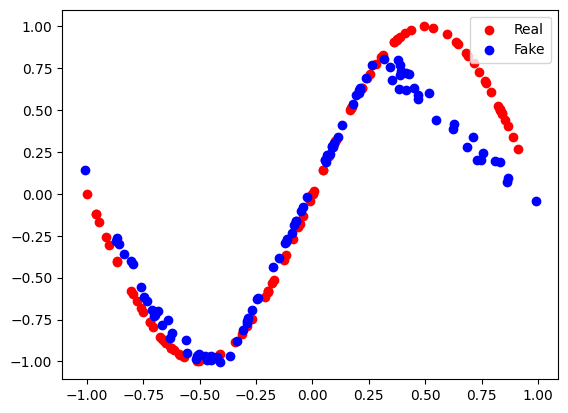

Epoch 44000: Real Acc: 0.60, Fake Acc: 0.61


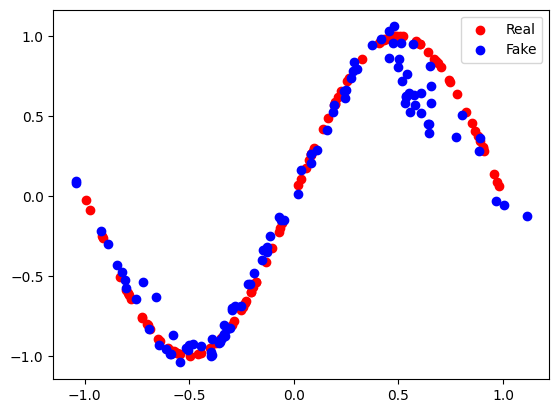

Epoch 46000: Real Acc: 0.40, Fake Acc: 0.65


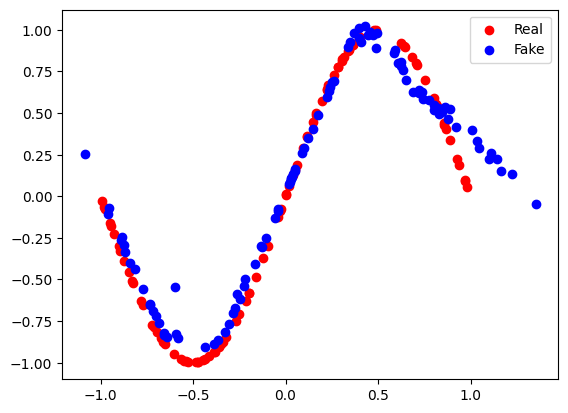

Epoch 48000: Real Acc: 0.60, Fake Acc: 0.54


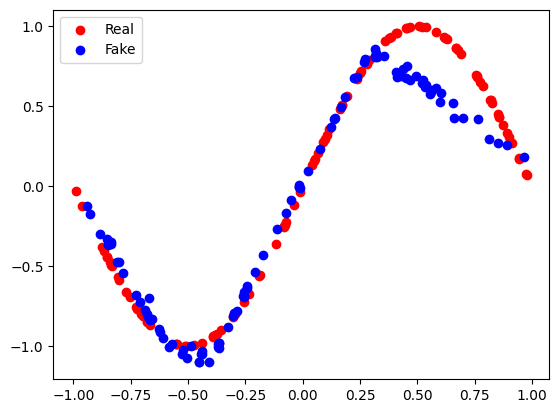

Epoch 50000: Real Acc: 0.60, Fake Acc: 0.48


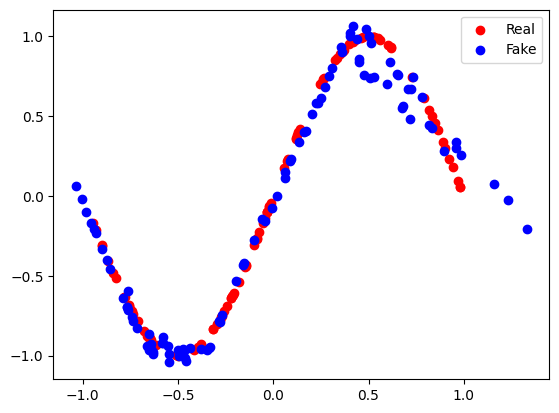

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the standalone discriminator model
class Discriminator(nn.Module):
    def __init__(self, n_inputs=2):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 25),
            nn.ReLU(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define the standalone generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, n_outputs=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 15),
            nn.ReLU(),
            nn.Linear(15, n_outputs)
        )

    def forward(self, x):
        return self.model(x)

# Generate n real samples with class labels
def generate_real_samples(n):
    # Generate a sine wave
    X1 = np.random.rand(n) * 2 - 1
    X2 = np.sin(np.pi * X1)    

    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    y = np.ones((n, 1))
    return torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device)

# Generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    x_input = np.random.rand(latent_dim * n) - 0.5
    x_input = x_input.reshape(n, latent_dim)
    return torch.tensor(x_input, dtype=torch.float32).to(device)

# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator(x_input)
    y = torch.zeros((n, 1), dtype=torch.float32).to(device)
    return X.detach(), y

# Evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    
    with torch.no_grad():
        y_pred_real = discriminator(x_real)
        y_pred_fake = discriminator(x_fake)
        
        acc_real = ((y_pred_real > 0.5).float() == y_real).float().mean().item()
        acc_fake = ((y_pred_fake > 0.5).float() == y_fake).float().mean().item()
    
    print(f'Epoch {epoch}: Real Acc: {acc_real:.2f}, Fake Acc: {acc_fake:.2f}')
    
    plt.scatter(x_real[:, 0].cpu(), x_real[:, 1].cpu(), color='red', label='Real')
    plt.scatter(x_fake[:, 0].cpu(), x_fake[:, 1].cpu(), color='blue', label='Fake')
    plt.legend()
    plt.show()

# Train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=50000, n_batch=256, n_eval=2000):
    half_batch = int(n_batch / 2)
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(d_model.parameters(), lr=0.001)
    g_optimizer = optim.Adam(g_model.parameters(), lr=0.001)
    
    for i in range(n_epochs):
        x_real, y_real = generate_real_samples(half_batch)
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # Train discriminator
        d_optimizer.zero_grad()
        y_pred_real = d_model(x_real)
        y_pred_fake = d_model(x_fake)
        d_loss_real = criterion(y_pred_real, y_real)
        d_loss_fake = criterion(y_pred_fake, y_fake)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        d_optimizer.step()
        
        # Train generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = torch.ones((n_batch, 1), dtype=torch.float32).to(device)
        g_optimizer.zero_grad()
        y_pred = gan_model(x_gan)
        g_loss = criterion(y_pred, y_gan)
        g_loss.backward()
        g_optimizer.step()
        
        # Evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i+1, g_model, d_model, latent_dim)

# Size of the latent space
latent_dim = 5
# Create the discriminator
discriminator = Discriminator().to(device)
# Create the generator
generator = Generator(latent_dim).to(device)
# Create the gan
gan_model = nn.Sequential(generator, discriminator).to(device)
# Train model
train(generator, discriminator, gan_model, latent_dim)
